In [3]:
from io import BytesIO
from zipfile import ZipFile, BadZipFile
import requests
from datetime import date, datetime
from pathlib import Path
import pandas_datareader.data as web
import datetime
import pandas as pd
import json
import re
from pprint import pprint
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

In [4]:
plt.style.use('fivethirtyeight')
data_path = Path('data') # perhaps set to external harddrive to accomodate large amount of data

## Dowload FS & Notes

The following code downloads and extracts all historical filings contained in the [Financial Statement and Notes](https://www.sec.gov/dera/data/financial-statement-and-notes-data-set.html) (FSN) datasets for the given range of quarters:

**Downloads over 40GB of data!**

In [3]:
SEC_URL = 'https://www.sec.gov/files/dera/data/financial-statement-and-notes-data-sets/'

today = pd.Timestamp(date.today())
this_year = today.year
this_quarter = today.quarter

past_years = range(2014, this_year)
filing_periods = [(y, q) for y in past_years for q in range(1, 5)]
filing_periods.extend([(this_year, q) for q in range(1, this_quarter + 1)])
for i, (yr, qtr) in enumerate(filing_periods, 1):
    print(yr, qtr, end=' ', )
    filing = f'{yr}q{qtr}_notes.zip'
    path = data_path / f'{yr}_{qtr}' / 'source'
    if not path.exists():
        path.mkdir(exist_ok=True, parents=True)

    response = requests.get(SEC_URL + filing).content
    try:
        with ZipFile(BytesIO(response)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                if local_file.exists():
                    continue
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
    except BadZipFile:
        continue

2014 1 2014 2 2014 3 2014 4 2015 1 2015 2 2015 3 2015 4 2016 1 2016 2 2016 3 2016 4 2017 1 2017 2 2017 3 2017 4 2018 1 2018 2 2018 3 2018 4 2019 1 

## Save to parquet

The data is fairly large and to enable faster access than the original text files permit, it is better to convert the text files to binary, columnar parquet format (see Section 'Efficient data storage with pandas' in chapter 2 for a performance comparison of various data-storage options compatible with pandas DataFrames):

In [4]:
for f in data_path.glob('**/*.tsv'):
    file_name = f.stem  + '.parquet'
    path = Path(f.parents[1]) / 'parquet'
    if (path / file_name).exists():
        continue
    if not path.exists():
        path.mkdir(exist_ok=True)
    try:
        df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False)
    except:
        print(f)
    df.to_parquet(path / file_name)

## Metadata json

In [5]:
file = data_path / '2018_3' / 'source' / '2018q3_notes-metadata.json'
with file.open() as f:
    data = json.load(f)

pprint(data)

{'@context': 'http://www.w3.org/ns/csvw',
 'dialect': {'delimiter': '\t', 'header': True, 'headerRowCount': 1},
 'tables': [{'tableSchema': {'aboutUrl': 'readme.htm',
                             'columns': [{'datatype': {'base': 'string',
                                                       'maxLength': 20,
                                                       'minLength': 20},
                                          'dc:description': 'Accession Number. '
                                                            'The 20-character '
                                                            'string formed '
                                                            'from the 18-digit '
                                                            'number assigned '
                                                            'by the Commission '
                                                            'to each EDGAR '
                                                           

## Data Organization

For each quarter, the FSN data is organized into eight file sets that contain information about submissions, numbers, taxonomy tags, presentation, and more. Each dataset consists of rows and fields and is provided as a tab-delimited text file:

| File | Dataset      | Description                                                 |
|------|--------------|-------------------------------------------------------------|
| SUB  | Submission   | Identifies each XBRL submission by company, form, date, etc |
| TAG  | Tag          | Defines and explains each taxonomy tag                      |
| DIM  | Dimension    | Adds detail to numeric and plain text data                  |
| NUM  | Numeric      | One row for each distinct data point in filing              |
| TXT  | Plain Text   | Contains all non-numeric XBRL fields                        |
| REN  | Rendering    | Information for rendering on SEC website                    |
| PRE  | Presentation | Detail on tag and number presentation in primary statements |
| CAL  | Calculation  | Shows arithmetic relationships among tags                   |

## Submission Data

The latest submission file contains around 6,500 entries.

In [9]:
sub = pd.read_parquet(data_path / '2018_3' / 'parquet' / 'sub.parquet')
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6492 entries, 0 to 6491
Data columns (total 40 columns):
adsh           6492 non-null object
cik            6492 non-null int64
name           6492 non-null object
sic            6490 non-null float64
countryba      6481 non-null object
stprba         5899 non-null object
cityba         6481 non-null object
zipba          6477 non-null object
bas1           6481 non-null object
bas2           2804 non-null object
baph           6481 non-null object
countryma      6447 non-null object
stprma         5905 non-null object
cityma         6447 non-null object
zipma          6446 non-null object
mas1           6447 non-null object
mas2           2761 non-null object
countryinc     5935 non-null object
stprinc        5631 non-null object
ein            6491 non-null float64
former         3618 non-null object
changed        3618 non-null float64
afs            6415 non-null object
wksi           6492 non-null int64
fye            6489 non-null

### Get AAPL submission

The submission dataset contains the unique identifiers required to retrieve the filings: the Central Index Key (CIK) and the Accession Number (adsh). The following shows some of the information about Apple's 2018Q1 10-Q filing:

In [10]:
name = 'APPLE INC'
apple = sub[sub.name == name].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'fy', 'fp', 'filed']
apple.loc[key_cols]

name                    APPLE INC
adsh         0000320193-18-000100
cik                        320193
name                    APPLE INC
sic                          3571
countryba                      US
stprba                         CA
cityba                  CUPERTINO
zipba                       95014
bas1           ONE APPLE PARK WAY
form                         10-Q
period                   20180630
fy                           2018
fp                             Q3
filed                    20180801
Name: 386, dtype: object

## Build AAPL fundamentals dataset

Using the central index key, we can identify all historical quarterly filings available for Apple, and combine this information to obtain 26 Forms 10-Q and nine annual Forms 10-K.

### Get filings

In [9]:
aapl_subs = pd.DataFrame()
for sub in data_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    aapl_sub = sub[(sub.cik.astype(int) == apple.cik) & (sub.form.isin(['10-Q', '10-K']))]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])

We find 15 quarterly 10-Q and 4 annual 10-K reports:

In [10]:
aapl_subs.form.value_counts()

10-Q    15
10-K     4
Name: form, dtype: int64

### Get numerical filing data

With the Accession Number for each filing, we can now rely on the taxonomies to select the appropriate XBRL tags (listed in the TAG file) from the NUM and TXT files to obtain the numerical or textual/footnote data points of interest.

First, let's extract all numerical data available from the 19 Apple filings:

In [11]:
aapl_nums = pd.DataFrame()
for num in data_path.glob('**/num.parquet'):
    num = pd.read_parquet(num).drop('dimh', axis=1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    print(len(aapl_num))
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format='%Y%m%d')   
aapl_nums.to_parquet(data_path / 'aapl_nums.parquet')

738
1345
707
961
1001
905
951
1277
937
751
923
793
1364
1271
682
805
942
919
952


In total, the nine years of filing history provide us with over 18,000 numerical values for AAPL.

In [12]:
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18224 entries, 84837 to 5467444
Data columns (total 15 columns):
adsh        18224 non-null object
tag         18224 non-null object
version     18224 non-null object
ddate       18224 non-null datetime64[ns]
qtrs        18224 non-null int64
uom         18224 non-null object
iprx        18224 non-null float64
value       18176 non-null float64
footnote    68 non-null object
footlen     18224 non-null int64
dimn        18224 non-null int64
coreg       0 non-null object
durp        18224 non-null float64
datp        18224 non-null float64
dcml        18224 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3), object(6)
memory usage: 2.2+ MB


## Create P/E Ratio from EPS and stock price data

We can select a useful field, such as Earnings per Diluted Share (EPS), that we can combine with market data to calculate the popular Price/Earnings (P/E) valuation ratio.

In [15]:
stock_split = 7
split_date = pd.to_datetime('20140604')
split_date

Timestamp('2014-06-04 00:00:00')

We do need to take into account, however, that Apple split its stock 7:1 on June 4, 2014, and Adjusted Earnings per Share before the split to make earnings comparable, as illustrated in the following code block:

In [16]:
# Filter by tag; keep only values measuring 1 quarter
eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')
                & (aapl_nums.qtrs == 1)].drop('tag', axis=1)

# Keep only most recent data point from each filing
eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))

# Adjust earnings prior to stock split downward
eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(7)
eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
eps = eps.rolling(4,min_periods=4).sum().dropna()

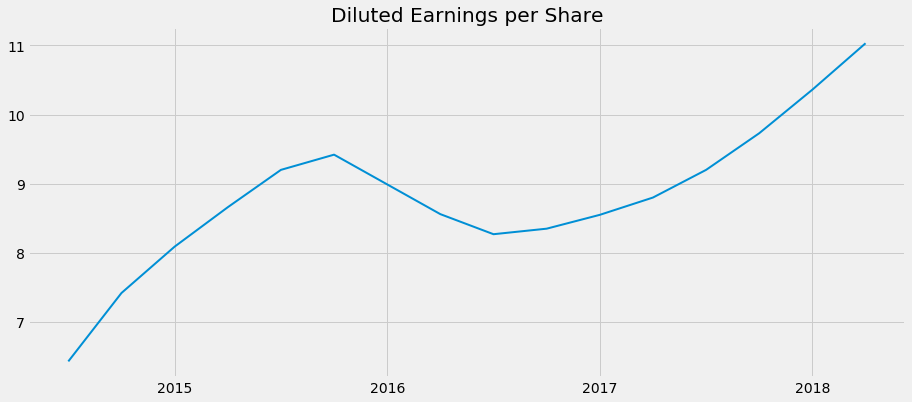

In [17]:
eps.plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
plt.xlabel('')
plt.savefig('diluted eps', dps=300);

In [18]:
symbol = 'AAPL.US'

aapl_stock = (web.
              DataReader(symbol, 'quandl', start=eps.index.min())
              .resample('D')
              .last()
             .loc['2014':eps.index.max()])
aapl_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1275 entries, 2014-09-30 to 2018-03-27
Freq: D
Data columns (total 12 columns):
Open          877 non-null float64
High          877 non-null float64
Low           877 non-null float64
Close         877 non-null float64
Volume        877 non-null float64
ExDividend    877 non-null float64
SplitRatio    877 non-null float64
AdjOpen       877 non-null float64
AdjHigh       877 non-null float64
AdjLow        877 non-null float64
AdjClose      877 non-null float64
AdjVolume     877 non-null float64
dtypes: float64(12)
memory usage: 129.5 KB


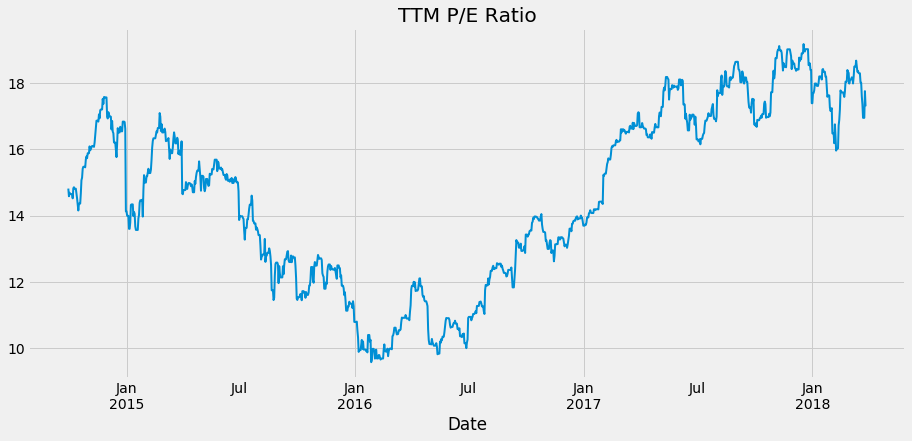

In [19]:
pe = aapl_stock.AdjClose.to_frame('price').join(eps.to_frame('eps'))
pe = pe.fillna(method='ffill').dropna()
pe['P/E Ratio'] = pe.price.div(pe.eps)
pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [20]:
pe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1275 entries, 2014-09-30 to 2018-03-27
Freq: D
Data columns (total 3 columns):
price        1275 non-null float64
eps          1275 non-null float64
P/E Ratio    1275 non-null float64
dtypes: float64(3)
memory usage: 39.8 KB


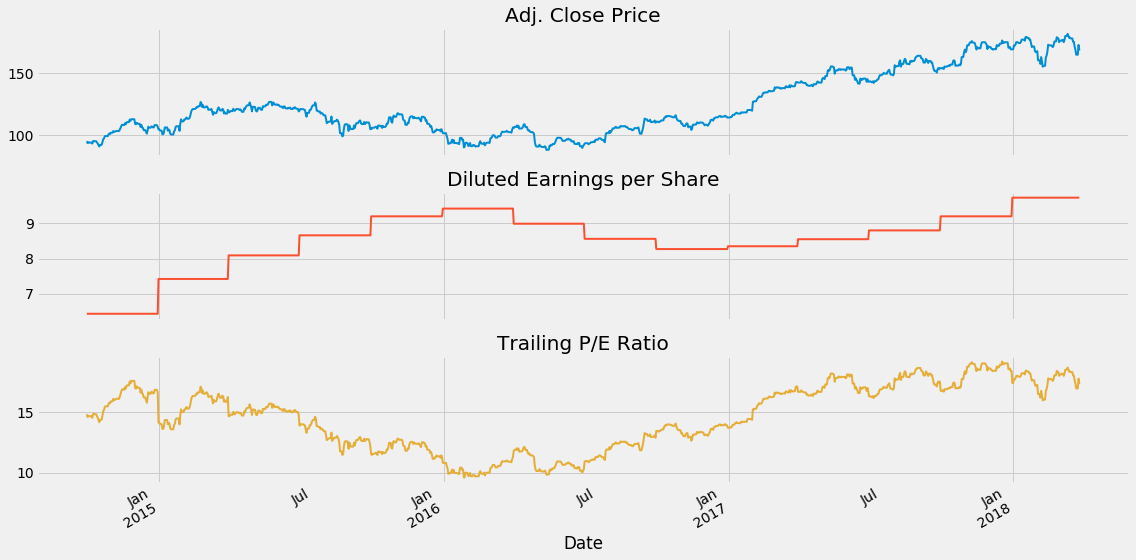

In [21]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

## Explore Additional Fields

The field `tag` references values defined in the taxonomy:

In [22]:
aapl_nums.tag.value_counts()

DebtInstrumentInterestRateEffectivePercentage                                                                        573
CashAndCashEquivalentsAtCarryingValue                                                                                570
SalesRevenueNet                                                                                                      544
AvailableForSaleSecuritiesNoncurrent                                                                                 532
AvailableForSaleSecurities                                                                                           532
AvailableForSaleSecuritiesCurrent                                                                                    532
AvailableForSaleSecuritiesAmortizedCost                                                                              532
AvailableForSaleSecuritiesAccumulatedGrossUnrealizedLossBeforeTax                                                    476
AvailableForSaleSecuritiesAccumu

We can select values of interest and track their value or use them as inputs to compute fundamental metrics like the Dividend/Share ratio.

### Dividends per Share

In [23]:
fields = ['EarningsPerShareDiluted',
          'PaymentsOfDividendsCommonStock',
          'WeightedAverageNumberOfDilutedSharesOutstanding',
          'OperatingIncomeLoss',
          'NetIncomeLoss',
          'GrossProfit']

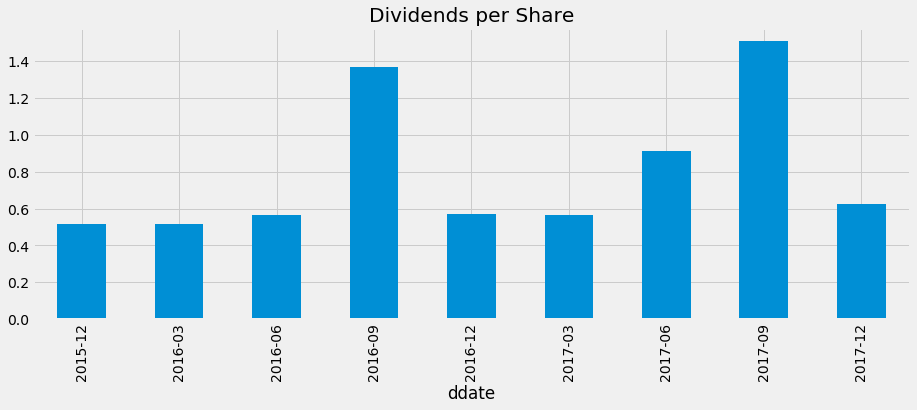

In [24]:
dividends = (aapl_nums
             .loc[aapl_nums.tag == 'PaymentsOfDividendsCommonStock', ['ddate', 'value']]
             .groupby('ddate')
             .mean())
shares = (aapl_nums
          .loc[aapl_nums.tag == 'WeightedAverageNumberOfDilutedSharesOutstanding', ['ddate', 'value']]
          .drop_duplicates()
          .groupby('ddate')
          .mean())
df = dividends.div(shares).dropna()
ax = df.plot.bar(figsize=(14, 5), title='Dividends per Share', legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%Y-%m')))

## Bonus: Textual Information

In [15]:
txt = pd.read_parquet(data_path / '2016_2' / 'parquet' /  'txt.parquet')

AAPL's adsh is not avaialble in the txt file but you can obtain notes from the financial statesments here:

In [17]:
txt.head()

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
0,0000014693-16-000160,AdvertisingCostsPolicyTextBlock,us-gaap/2015,20160430,4,0,en-US,32767,0.0,0.0,0x00000000,0,None,1,425,112,None,0,FD2016Q4YTD,Advertising costs. We expense the costs of adv...
1,0000014693-16-000160,AmendmentFlag,dei/2014,20160430,4,0,en-US,32767,0.0,0.0,0x00000000,0,None,0,5,5,None,0,FD2016Q4YTD,false
2,0000014693-16-000160,ComprehensiveIncomeNoteTextBlock,us-gaap/2015,20160430,4,0,en-US,32767,0.0,0.0,0x00000000,0,None,1,82857,2106,None,0,FD2016Q4YTD,ACCUMULATED OTHER COMPREHENSIVE INCOME The fol...
3,0000014693-16-000160,EntityFilerCategory,dei/2014,20160430,4,0,en-US,32767,0.0,0.0,0x00000000,0,None,0,23,23,None,0,FD2016Q4YTD,Large Accelerated Filer
4,0000014693-16-000160,ScheduleOfComprehensiveIncomeLossTableTextBlock,us-gaap/2015,20160430,4,0,en-US,32767,0.0,0.0,0x00000000,0,None,1,67007,1686,None,0,FD2016Q4YTD,The following table presents the components of...
